In [10]:
library(Seurat)
library(data.table) 
library(ggplot2)
library(plyr)


## Visualisation of HTODemux result
### UMAP plot

11:04:34 Annoy recall = 100%

11:04:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:04:34 Initializing from normalized Laplacian + noise (using irlba)

11:04:34 Commencing optimization for 500 epochs, with 104424 positive edges

11:04:36 Optimization finished



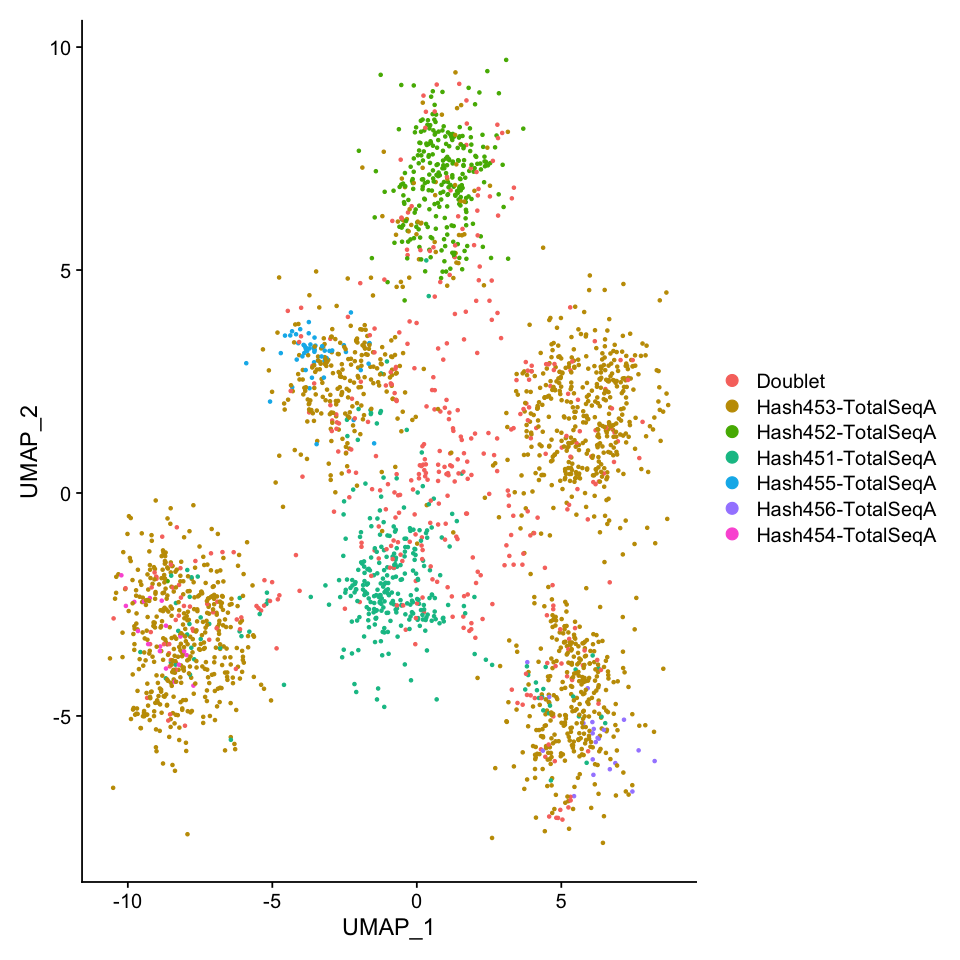

In [3]:
# Load htodemux result from an rds object
htodemux_gx38 <- readRDS("../data/pipeline_output/gx38/htodemux.rds")

# Subset the object, remove negative droplets
htodemux_gx38.subset <- subset(htodemux_gx38, idents = "Negative", invert = TRUE)

# Calculate a tSNE embedding of the HTO data
DefaultAssay(htodemux_gx38.subset) <- "HTO"
htodemux_gx38.subset <- ScaleData(htodemux_gx38.subset, features = rownames(htodemux_gx38.subset),
    verbose = FALSE)
htodemux_gx38.subset <- RunPCA(htodemux_gx38.subset, features = rownames(htodemux_gx38.subset), approx = FALSE)
htodemux_gx38.subset <- RunUMAP(htodemux_gx38.subset, dims = 1:6)

DimPlot(htodemux_gx38.subset,reduction = "umap") 


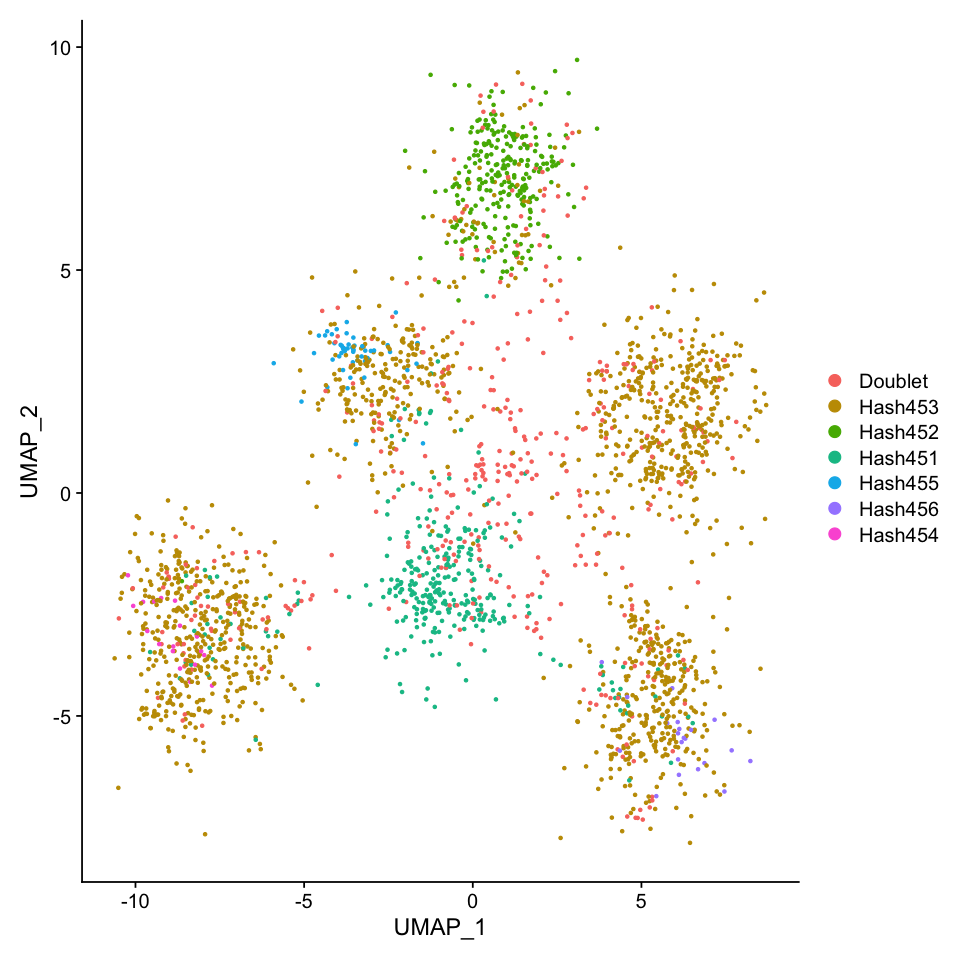

In [4]:
# Rename the features
DimPlot(htodemux_gx38.subset) + scale_color_hue(labels = c("Doublet", paste0("Hash45", c(3,2,1,5,6,4))))
# ggsave("S1-umap-gx38.png", dpi = 300, height = 5, width = 6)

### Ridge plot

Picking joint bandwidth of 0.0227

Picking joint bandwidth of 0.0296

Picking joint bandwidth of 0.0259

Picking joint bandwidth of 0.0248

Picking joint bandwidth of 0.0615

Picking joint bandwidth of 0.0324

Picking joint bandwidth of 0.0227

Picking joint bandwidth of 0.0296

Picking joint bandwidth of 0.0259

Picking joint bandwidth of 0.0248

Picking joint bandwidth of 0.0615

Picking joint bandwidth of 0.0324



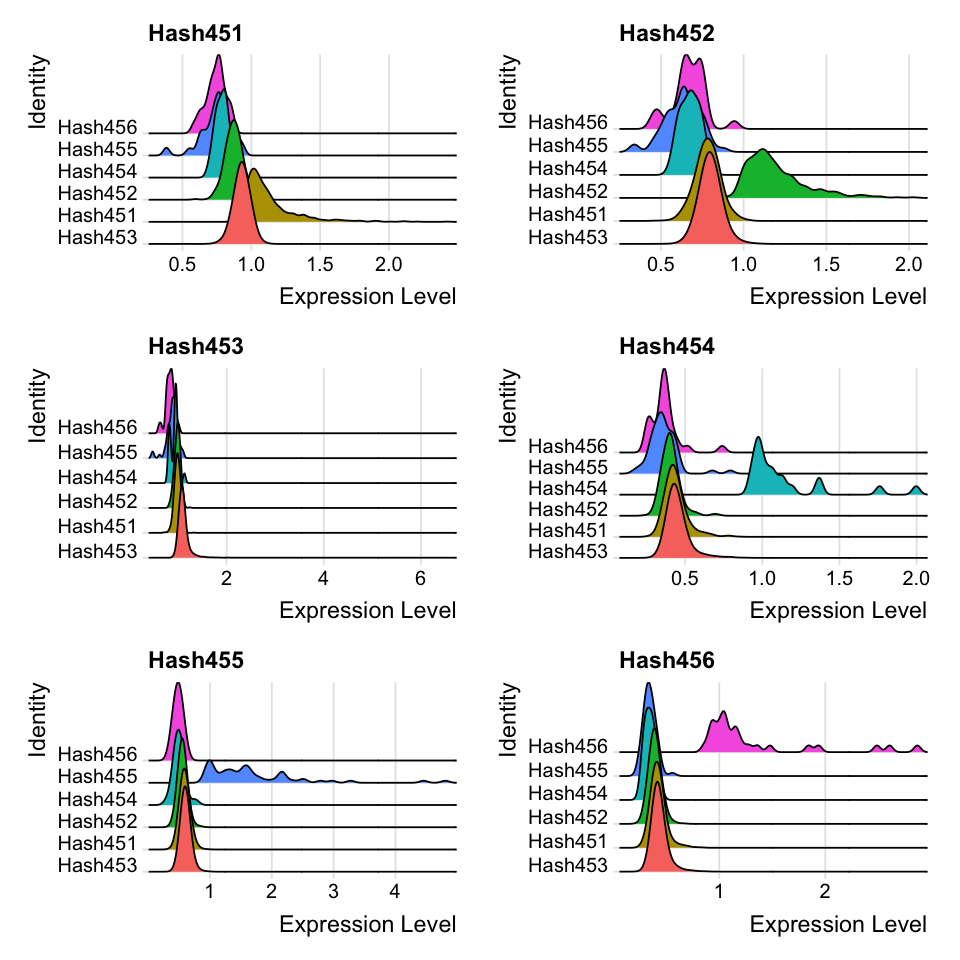

In [5]:
# Rename features
htodemux_gx38[["HTO"]]@counts@Dimnames[[1]] <- paste0("Hash45", 1:6)
dimnames(htodemux_gx38[["HTO"]]@data)[[1]] <- paste0("Hash45", 1:6)
htodemux_gx38 <- RenameIdents(htodemux_gx38, 'Hash453-TotalSeqA' = 'Hash453', 'Hash451-TotalSeqA' = 'Hash451', 'Hash452-TotalSeqA' = 'Hash452', 'Hash454-TotalSeqA' = 'Hash454',
    'Hash455-TotalSeqA' = 'Hash455', 'Hash456-TotalSeqA' = 'Hash456')
# Group cells based on the max HTO signal
Idents(htodemux_gx38) <- "HTO_maxID"
htodemux_gx38 <- RenameIdents(htodemux_gx38, 'Hash453-TotalSeqA' = 'Hash453', 'Hash451-TotalSeqA' = 'Hash451', 'Hash452-TotalSeqA' = 'Hash452', 'Hash454-TotalSeqA' = 'Hash454',
    'Hash455-TotalSeqA' = 'Hash455', 'Hash456-TotalSeqA' = 'Hash456')

RidgePlot(htodemux_gx38, assay = "HTO", features = rownames(htodemux_gx38[["HTO"]]), ncol = 2)
# ggsave("S2-ridge-gx38.png", dpi = 300, height = 7, width = 7)

### heatmap

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


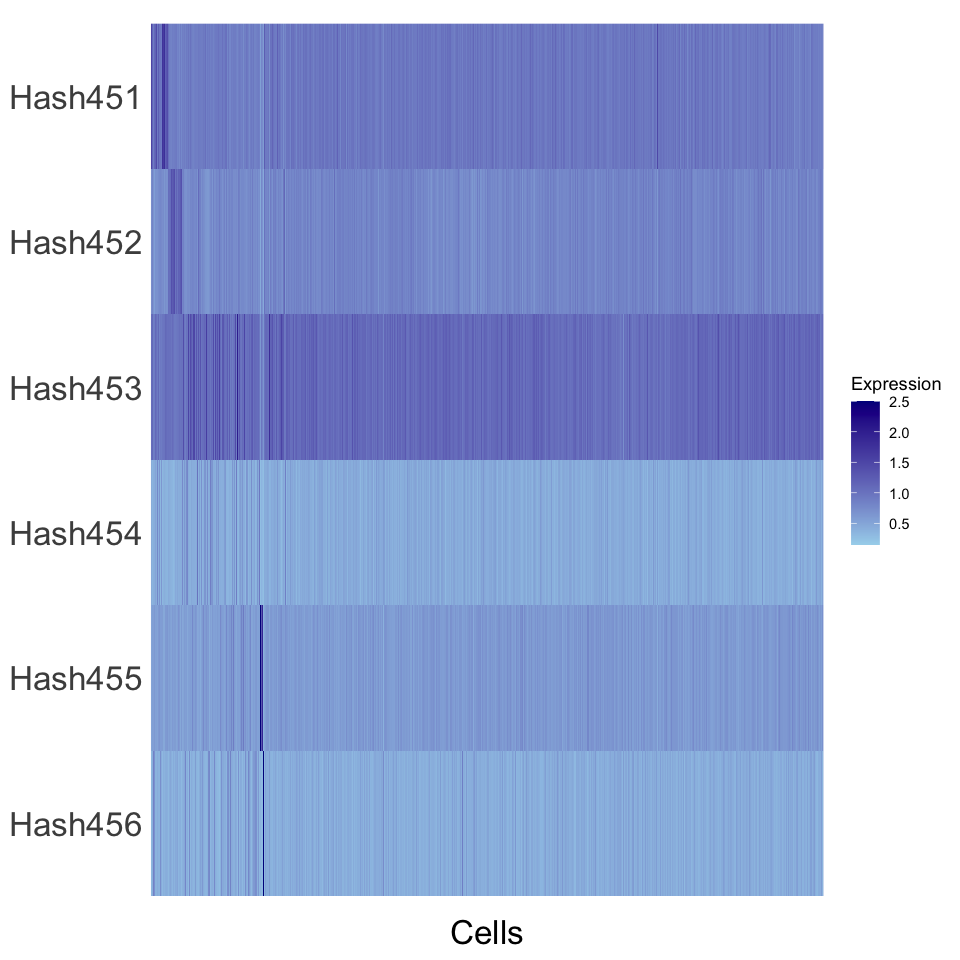

In [6]:
# Rename features
htodemux_gx38[["HTO_classification"]]$HTO_classification <- gsub('-TotalSeqA', '', htodemux_gx38[["HTO_classification"]]$HTO_classification)

HTOHeatmap(htodemux_gx38, assay = "HTO", ncells=12585) + xlab("Cells") + 
scale_fill_gradient(low = "#a6d5ed", high = "darkblue", guide = "colorbar") + 
    theme(axis.text=element_text(size=20), axis.title=element_text(size=20))
# ggsave("S3-heatmap-gx38.png", dpi = 300, height = 5, width = 7)

### Load hashing deconvolution results

In [7]:
# Load hashing deconvolution results
hash_gx38_classi <-fread("../data/pipeline_output/gx38/hash_classification_all.csv")

# Remove the trial ID
colnames(hash_gx38_classi) <- gsub("_1", "", colnames(hash_gx38_classi))

# Subset by only those cells detected by RNA
white_list_gx38 <- fread("../data/dataset/barcodes_gx38.tsv", header = F)$V1
hash_gx38_classi <- hash_gx38_classi[Barcode %in% white_list_gx38,]

# remove doublet detection method solo
hash_gx38_classi <- hash_gx38_classi[,1:6]

head(hash_gx38_classi)

Barcode,demuxem,hashedDrops,hashsolo,htodemux,multiseq
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGATGAGA-1,negative,negative,doublet,negative,singlet
AAACCCAAGGTACCTT-1,negative,negative,doublet,negative,negative
AAACCCAAGTCATTGC-1,singlet,negative,doublet,negative,singlet
AAACCCAAGTTGGAGC-1,singlet,negative,doublet,negative,singlet
AAACCCACAAGGCTTT-1,negative,negative,doublet,negative,singlet
AAACCCACACACAGCC-1,doublet,negative,doublet,singlet,doublet


## Visualisation of hashing deconvolution results

In [8]:
# Reorder the result
summary_hash_gx38 <- melt(hash_gx38_classi, id.vars = "Barcode", variable.name = "Method", 
                          value.name = "Classification")
summary_hash_gx38 <- na.omit(summary_hash_gx38)
summary_hash_gx38 <- as.data.frame(table(summary_hash_gx38[,-1]))
colnames(summary_hash_gx38)[3] <- "Count" 
summary_hash_gx38 <- summary_hash_gx38[order(summary_hash_gx38$Classification, decreasing = T),]
head(summary_hash_gx38)

,Method,Classification,Count
,<fct>,<fct>,<int>
11,demuxem,singlet,5210
12,hashedDrops,singlet,97
13,hashsolo,singlet,1043
14,htodemux,singlet,2124
15,multiseq,singlet,7468
6,demuxem,negative,6310


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


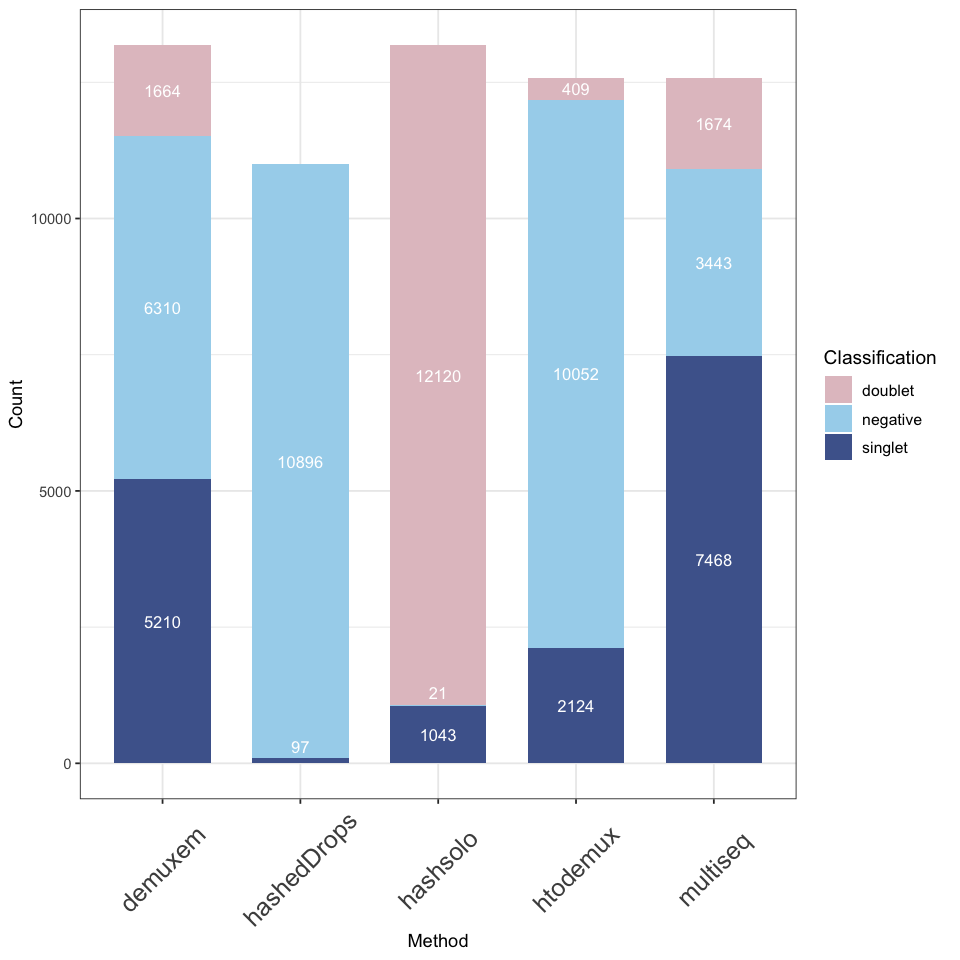

In [11]:
# Determine the y-axis position of labels ylab_pos
summary_hash_gx38_cumsum <- ddply(summary_hash_gx38, "Method", transform, 
                                  label_ypos=cumsum(Count)- 0.5*Count)
# Modify the ylab_pos manually
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Method=="hashsolo" & summary_hash_gx38_cumsum$Classification=="negative",]$label_ypos <- 1300
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Method=="hashedDrops" & summary_hash_gx38_cumsum$Classification=="singlet",]$label_ypos <- 300

# Avoid showing count 0
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Count==0,]$label_ypos <- NA

# Barplot
ggplot(summary_hash_gx38_cumsum, aes(x=Method, y=Count, fill=Classification)) + geom_bar(stat="identity", width=0.7) +
    scale_fill_manual(values = c("#E2C3C9", "#a6d5ed", "#4e659b")) + theme_bw() +
    geom_text(aes(y=label_ypos, label=Count), vjust=0.5, color="white", size=3.5) +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, size = 15), legend.text=element_text(size=9.5),
    legend.title=element_text(size=11.5))


# ggsave("S4-hash-bar-gx38.png", dpi = 300, height = 6, width = 7)

## Visualisation of genetic deconvolution results

In [12]:
# Load genetic demultiplexing results
gene_gx38_classi <-fread("../data/pipeline_output/gx38/genetic_classification_all.csv")

# Remove the trial ID
colnames(gene_gx38_classi) <- gsub("_1", "", colnames(gene_gx38_classi))

In [13]:
# Load genetic demultiplexing results
gene_gx38_classi <-fread("../data/pipeline_output/gx38/genetic_classification_all.csv")

# Remove the trial ID
colnames(gene_gx38_classi) <- gsub("_1", "", colnames(gene_gx38_classi))

# Reorder the result
summary_gene_gx38 <- melt(gene_gx38_classi, id.vars = "Barcode", variable.name = "Method", 
                          value.name = "Classification")
summary_gene_gx38 <- na.omit(summary_gene_gx38)
summary_gene_gx38 <- as.data.frame(table(summary_gene_gx38[,-1]))
colnames(summary_gene_gx38)[3] <- "Count" 
summary_gene_gx38 <- summary_gene_gx38[order(summary_gene_gx38$Classification, decreasing = T),]
head(summary_gene_gx38)

,Method,Classification,Count
,<fct>,<fct>,<int>
9,freemuxlet,singlet,11908
10,scsplit,singlet,10604
11,souporcell,singlet,11269
12,vireo,singlet,10351
5,freemuxlet,negative,17
6,scsplit,negative,0


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


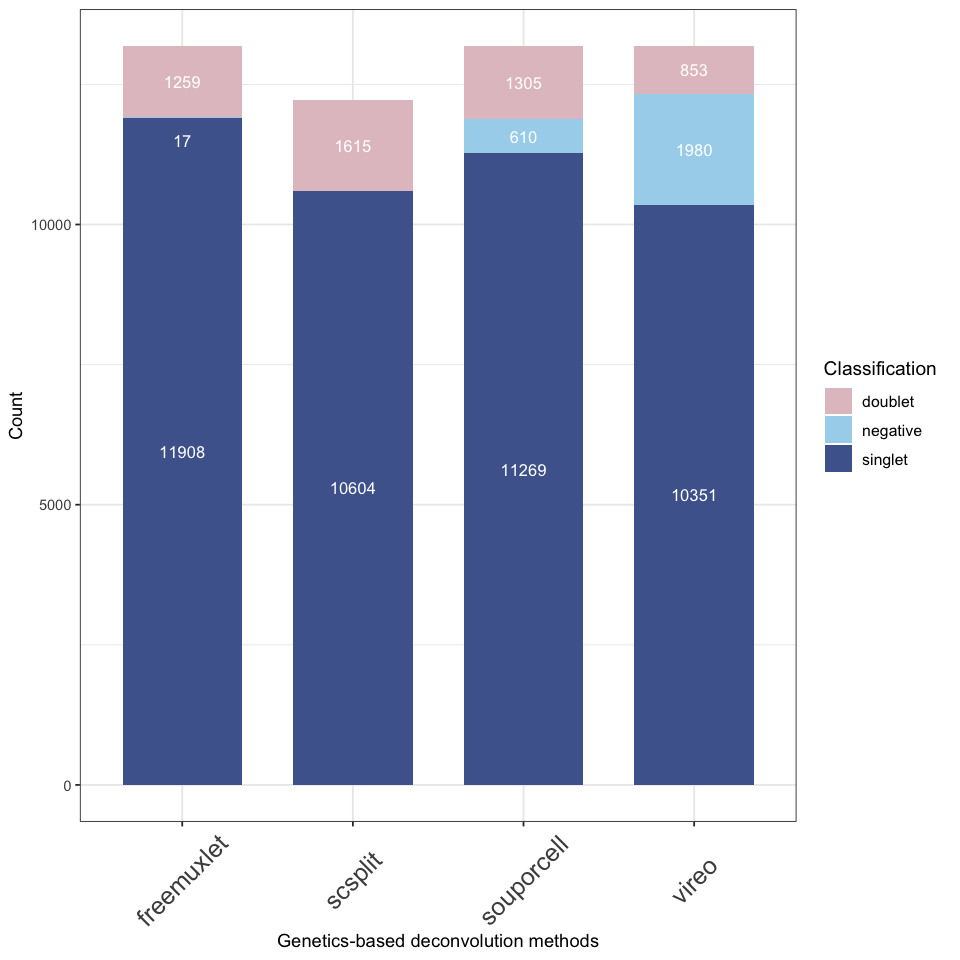

In [14]:
# Determine the y-axis position of labels ylab_pos
summary_gene_gx38_cumsum <- ddply(summary_gene_gx38, "Method", transform, 
                                  label_ypos=cumsum(Count)- 0.5*Count)

# Avoid showing count 0
summary_gene_gx38_cumsum[summary_gene_gx38_cumsum$Count==0,]$label_ypos <- NA

# Modify the ylab_pos manually
summary_gene_gx38_cumsum[summary_gene_gx38_cumsum$Method=="freemuxlet" & 
                         summary_gene_gx38_cumsum$Classification=="negative",]$label_ypos <- 11500

# Barplot
ggplot(summary_gene_gx38_cumsum, aes(x=Method, y=Count, fill=Classification)) + geom_bar(stat="identity", width=0.7) +
    scale_fill_manual(values = c("#E2C3C9", "#a6d5ed", "#4e659b")) + theme_bw() + 
    xlab("Genetics-based deconvolution methods") +
    geom_text(aes(y=label_ypos, label=Count), vjust=0.5, color="white", size=3.5) +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, size = 15), legend.text=element_text(size=9.5),
    legend.title=element_text(size=11.5))


# ggsave("S13-gene-bar-gx38.png", dpi = 300, height = 6, width = 7)